# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Definicja stałych

In [2]:
# generowanie odcinków
MIN_X = 0
MIN_Y = 0

# typy zdarzeń
BEG = 0
END = 1
INTERSECT = 2

# konfiguracja wizualizacji
BROOM = {"color" : "red", "linestyle" : '--', "linewidth" : 2}
IN_EVENTS_STRUCT = {"color" : ["green"]}
CURRENT_VERTEX = {"color" : ["cyan"]}
PROCESSED_VERTICIES = {"color" : ["blue"]}
FOUND_INTERSECTION_POINT = {"color" : ["red"], "s" : 70}
IN_BROOM_STRUCT = {"color" : ["purple"]}
PROCESSED_SEGMENTS = {"color" : ["blue"]}
NOT_PROCESSED_SEGMENTS = {"color" : ["orange"]}

# Przydatne funkcje 

In [3]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()

def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


In [4]:
def draw_segments(segments):
    plt.close("all")
    vis = Visualizer()
    vis.add_line_segment(segments)
    vis.show()

In [5]:
def draw_intersections(segments, intersections):
    plt.close("all")
    intersectionsPoints = [intersection[0] for intersection in intersections]
    vis = Visualizer()
    vis.add_line_segment(segments)
    vis.add_point(intersectionsPoints, **FOUND_INTERSECTION_POINT)
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

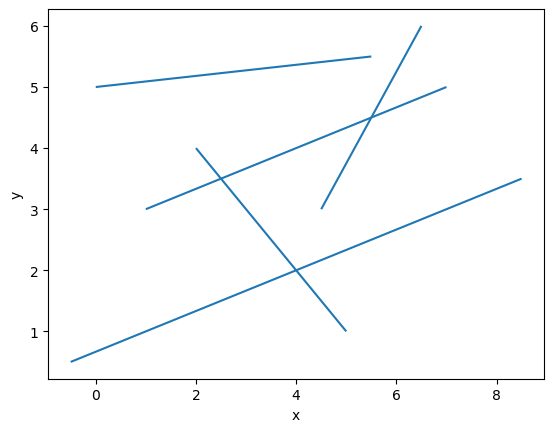

In [6]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

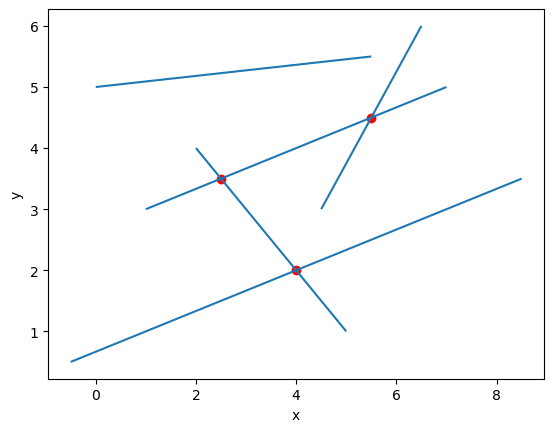

In [7]:
draw_example_2()

## Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [8]:
import random

In [9]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów.
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """

    uniformSections = []
    sectionsEndsXCoordinate = set()

    while len(uniformSections) < n:
        x1 = random.uniform(MIN_X, max_x)
        x2 = random.uniform(MIN_X, max_x)

        if x1 == x2 or x1 in sectionsEndsXCoordinate or x2 in sectionsEndsXCoordinate:
            continue

        sectionsEndsXCoordinate.add(x1)
        sectionsEndsXCoordinate.add(x2)

        y1 = random.uniform(MIN_Y, max_y)
        y2 = random.uniform(MIN_Y, max_y)

        section = ((x1, y1), (x2, y2))
        uniformSections.append(section)

    return uniformSections

In [10]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.092s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [11]:
sections = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

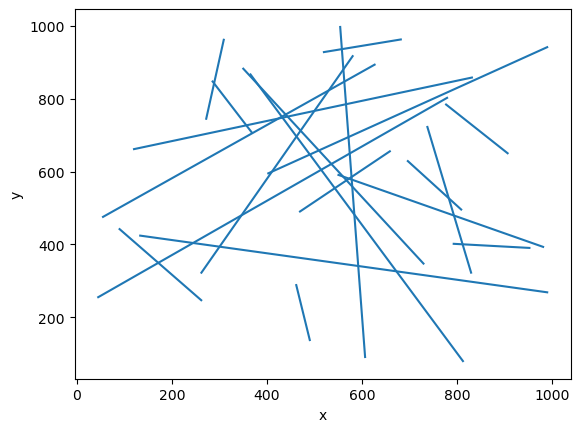

In [12]:
%matplotlib inline
draw_segments(sections)

## Wprowadzenie odcinków myszką

Uzupełnij funkcję ```get_segments``` #interaktywne dodawanie odcinków przez rysowanie myszką

In [13]:
def get_segments():
    """
    Odczytuje punkty wprowadzone przez użytkownika myszką i zwraca listę odcinków jako krotki punktów, które są
    krotkami liczb zmiennoprzecinkowych.
    Wewnątrz Jupyter Notebook używać wraz z ***%matplotlib widget***

    :return list of tuple: Lista, w której każdy element jest krotką krotek reprezentujących odcinki ((x1, y1), (x2, y2)).
    """
    # Event handler for mouse click
    def on_click(event):
        nonlocal pickSegmentBeg, segmentBegX, segmentBegY
        # Check if it's a left-click within the axes
        if event.button == 1 and event.inaxes == ax:
            # Append the point and update the plot
            currX, currY = event.xdata, event.ydata
            ax.scatter(currX, currY, color = "blue", marker = 'o')  # Mark the point

            # check if it is first or second point in line segment
            if pickSegmentBeg:
                segmentBegX, segmentBegY = currX, currY
            else:
                xs = [segmentBegX, currX]
                ys = [segmentBegY, currY]
                ax.plot(xs, ys, color = "blue")
                segment = ((segmentBegX, segmentBegY), (currX, currY))
                segments.append(segment)

            # update information about point type
            pickSegmentBeg = not pickSegmentBeg

            # update plot
            plt.draw()

        # If right-click, close the polygon by connecting to the first point
        elif event.button == 3 and pickSegmentBeg:
            plt.draw()
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event
            # plt.close(fig)

    plt.close('all')    # close all opened plots

    segments = []
    pickSegmentBeg = True
    segmentBegX, segmentBegY = None, None

    fig, ax = plt.subplots(num = "get line segments")
    ax.set_title("Left-click to select points; right-click to finish")

    # Connect the event handler
    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

    return segments

Dodaj odcinki wprowadzając je myszką

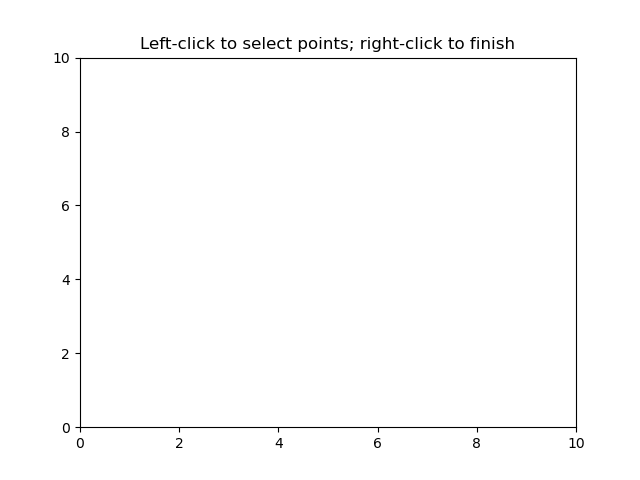

In [14]:
%matplotlib widget
segments = get_segments()

Zwizualizuj wprowadzone odcinki

[((np.float64(2.6411290322580645), np.float64(7.391774891774892)), (np.float64(8.185483870967742), np.float64(3.928571428571429))), ((np.float64(2.8024193548387095), np.float64(3.5768398268398274)), (np.float64(7.338709677419354), np.float64(6.255411255411256))), ((np.float64(8.407258064516128), np.float64(5.606060606060606)), (np.float64(2.338709677419355), np.float64(6.363636363636364))), ((np.float64(6.491935483870968), np.float64(9.177489177489178)), (np.float64(1.0483870967741935), np.float64(3.6309523809523814))), ((np.float64(0.0), np.float64(5.037878787878788)), (np.float64(5.766129032258064), np.float64(3.27922077922078))), ((np.float64(8.48790322580645), np.float64(1.0335497835497836)), (np.float64(3.0645161290322585), np.float64(0.6006493506493507))), ((np.float64(0.9274193548387095), np.float64(1.222943722943723)), (np.float64(5.02016129032258), np.float64(1.682900432900433)))]


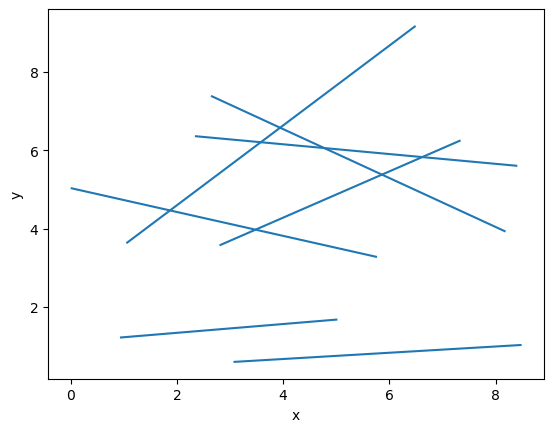

In [15]:
%matplotlib inline
draw_segments(segments)
print(segments)

## Wczytywanie odcinków z pliku

In [16]:
def load_segments_from_file(pathToFile: str):
    loadedSegments = []
    try:
        with open(pathToFile, 'r') as file:
            for line in file:
                beg1, end1, beg2, end2 = list(map(np.float64, line.strip().split()))
                loadedSegments.append(((beg1, end1), (beg2, end2)))
    except FileNotFoundError:
        print(f"File '{pathToFile}' not found.")
    except ValueError:
        print("Invalid format in file. Each line should contain four floats separated by whitespace.")

    return loadedSegments

In [17]:
pathToFile = "./test_segments/test1"
loadedSegments1 = load_segments_from_file(pathToFile)

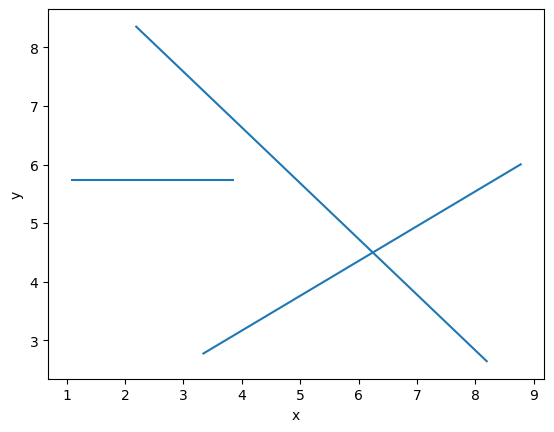

In [18]:
draw_segments(loadedSegments1)

## Wykorzystywane struktury

In [19]:
from sortedcontainers import SortedSet

In [20]:
class Point:
    def __init__(self, point: tuple[float, float]) -> None:
        self.point = point

    def get_point(self):
        return self.point

    def get_x(self):
        return self.point[0]

    def get_y(self):
        return self.point[1]

    def __lt__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() < other.get_x()

    def __le__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() <= other.get_x()

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Point):
            return NotImplemented
        return self.point == value.point

    def __hash__(self) -> int:
        return hash(self.point)

    def __repr__(self) -> str:
        return f"Point({self.get_x()}, {self.get_y()})"

In [21]:
class Segment:
    # współdzielona wartość obecnej wpółrzędnej x

    x = None

    def __init__(self, idx: int, beg: Point, end: Point) -> None:
        self.idx = idx

        # ustawienie początku jako punktu z mniejszą wartością współrzędnej x
        if end < beg:
            beg, end = end, beg

        self.beg = beg
        self.end = end

        # wyznaczenie współczynników a i b do równania kierunkowego prostej
        self.a = (end.get_y() - beg.get_y()) / (end.get_x() - beg.get_x())
        self.b = -self.a * beg.get_x() + beg.get_y()

    @staticmethod
    def update_x(x):
        Segment.x = x

    def get_segment(self):
        return (self.beg.get_point(), self.end.get_point())

    def get_idx(self):
        return self.idx

    def get_beg(self):
        return self.beg

    def get_end(self):
        return self.end

    def get_a(self):
        return self.a

    def get_b(self):
        return self.b

    def calculate_y_coordinate(self):
        return self.a * Segment.x + self.b

    def __lt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented

        thisY = self.calculate_y_coordinate()
        otherY = other.calculate_y_coordinate()

        return thisY < otherY

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Segment):
            return NotImplemented
        return self.get_beg() == value.get_beg() and self.get_end() == value.get_end()

    def __hash__(self) -> int:
        return hash((self.beg, self.end))

    def __repr__(self) -> str:
        return f"Segment({self.beg}, {self.end})"

In [22]:
class Event:
    def __init__(self, point: Point, eventType, segmentsList: list[Segment]) -> None:
        self.point = point
        self.eventType = eventType
        self.segmentsList = segmentsList

    def get_event_point(self):
        return self.point

    def get_event_type(self):
        return self.eventType

    def get_event_segments_list(self):
        return self.segmentsList

    def __lt__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__lt__(other.get_event_point())

    def __le__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__le__(other.get_event_point())

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Event):
            return NotImplemented
        return self.eventType == value.eventType and self.get_event_point() == value.get_event_point()

    def __hash__(self) -> int:
        return hash((self.point, self.eventType))

    def __repr__(self) -> str:
        return f"Event({self.point, self.eventType})"

Uzupełnij funkcję ```get_segments_intersection``` znajdującą przecięcie dwóch odcinków

In [23]:
def mat_det_2x2(kx1, kx2, ky1, ky2):
    """
    Obliczanie wyznacznika macierzy 2x2 bez użycia funkcji bibliotecznych

    :param kx1: współczynnik przed x w pierwszym równaniu
    :param kx2: współczynnik przed x w drugim równaniu
    :param ky1: współczynnik przed y w pierwszym równaniu
    :param ky2: współczynnik przed y w drugim równaniu
    :return: wartość wyznacznika macierzy
    """

    return kx1 * ky2 - kx2 * ky1

In [24]:
def get_segments_intersection(segment1: Segment, segment2: Segment) -> Point:
    """
    Wyznacza punkt przecięcia odcinków

    :param segment1: pierwszy odcinek
    :param segment2: drugi odcinek
    :return: punkt przecięcia odcinków
    """
    if segment1.get_a() == segment2.get_a():
        return None

    W = mat_det_2x2(segment1.get_a(), segment2.get_a(), -1, -1)
    Wx = mat_det_2x2(-segment1.get_b(), -segment2.get_b(), -1, -1)
    Wy = mat_det_2x2(segment1.get_a(), segment2.get_a(), -segment1.get_b(), -segment2.get_b())

    intersectPoint = Point((Wx / W, Wy / W))

    if segment1.get_beg().get_x() < intersectPoint.get_x() < segment1.get_end().get_x() \
       and segment2.get_beg().get_x() < intersectPoint.get_x() < segment2.get_end().get_x():
        return intersectPoint

    return None

## Przecinanie się odcinków

Uzupełnij funkcję ```is_intersection```

In [25]:
def is_intersection_handle_event_beg(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    return foundIntersection

In [26]:
def is_intersection_handle_event_end(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            foundIntersection =True

    broomStateStruct.remove(toRemoveSegment)

    return foundIntersection

In [27]:
def is_intersection(segments):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina

    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :return: True / False
    """

    isIntersection = False

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(None, Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        if eventType == BEG:
            if is_intersection_handle_event_beg(event, broomStateStruct):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_handle_event_end(event, broomStateStruct):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")

    return isIntersection

In [28]:
isIntersection = is_intersection(segments)
print(isIntersection)

True


In [29]:
isIntersection = is_intersection(loadedSegments1)
print(isIntersection)

True


In [30]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

In [31]:
# Odpowiedź here
# TODO: answer

Uzupełnij funkcję ```is_intersection_with_visualization```

In [32]:
def get_broom(point: Point):
    return ((point.get_x(), 0), (point.get_x(), 1))

In [33]:
def is_intersection_with_visualization_handle_event_beg(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # dodanie wizualizacji dodania nowego odcinka do struktury stanu miotły
    vis.add_line_segment(eventSegment.get_segment(), **IN_BROOM_STRUCT)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    return False

In [34]:
def is_intersection_with_visualization_handle_event_end(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            vis.add_point(neighboursIntersectPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    broomStateStruct.remove(toRemoveSegment)

    # wizualizacja usunięcia odcinka ze struktury miotły
    vis.add_line_segment(toRemoveSegment.get_segment(), **PROCESSED_SEGMENTS)

    return False

In [35]:
def is_intersection_with_visualization(segments):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji
    :param segments: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """

    # ustawienie początkowe vizualizera
    vis = Visualizer()
    vis.add_line_segment(segments, **NOT_PROCESSED_SEGMENTS)
    broom = None
    broomVis = None
    prevPoint = None

    isIntersection = False

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(None, Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    # wyświetlenie wszystkich punktów stanowiących zdarzenia
    points = [event.get_event_point().get_point() for event in eventsSortedSet]
    vis.add_point(points, **IN_EVENTS_STRUCT)

    firstEvent: Event = eventsSortedSet.pop(0)

    # wizualizacja pierwszego zdarzenia
    firstEventPoint = firstEvent.get_event_point()
    broom = get_broom(firstEventPoint)
    vis.add_point(firstEventPoint.get_point(), **CURRENT_VERTEX)
    broomVis = vis.add_line(broom, **BROOM)
    prevPoint = firstEventPoint

    firstEventSegment = firstEvent.get_event_segments_list()[0]

    broomStateStruct.add(firstEventSegment)

    # dodanie nowego odcinka do struktury miotły
    vis.add_line_segment(firstEventSegment.get_segment(), **IN_BROOM_STRUCT)

    while len(eventsSortedSet) > 0:
        # zaznaczenie przetworzonego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)

        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        eventPoint = event.get_event_point()

        # dodanie wizualizacji obecnego punktu
        vis.remove_figure(broomVis)
        broom = get_broom(eventPoint)
        broomVis = vis.add_line(broom, **BROOM)
        vis.add_point(eventPoint.get_point(), **CURRENT_VERTEX)
        prevPoint = eventPoint

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        if eventType == BEG:
            if is_intersection_with_visualization_handle_event_beg(event, broomStateStruct, vis):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_with_visualization_handle_event_end(event, broomStateStruct, vis):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")


    if isIntersection:
        vis.add_title("znaleziono punkt przecięcia")
    else:
        # zaznaczenie przetworzenia ostatniego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)
        vis.add_title("nie znaleziono punktu przecięcia")

    return isIntersection, vis

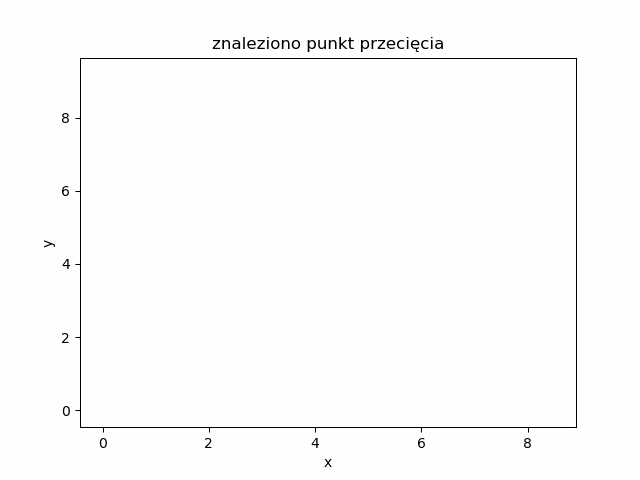

In [36]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(segments)
vis.show_gif(interval = 250)

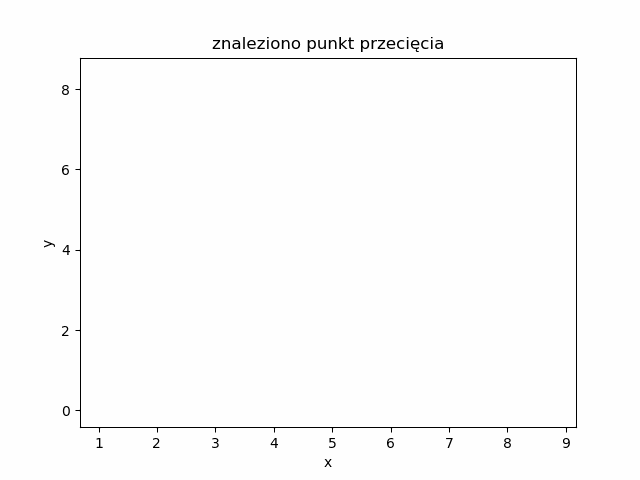

In [37]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(loadedSegments1)
vis.show_gif(interval = 250)

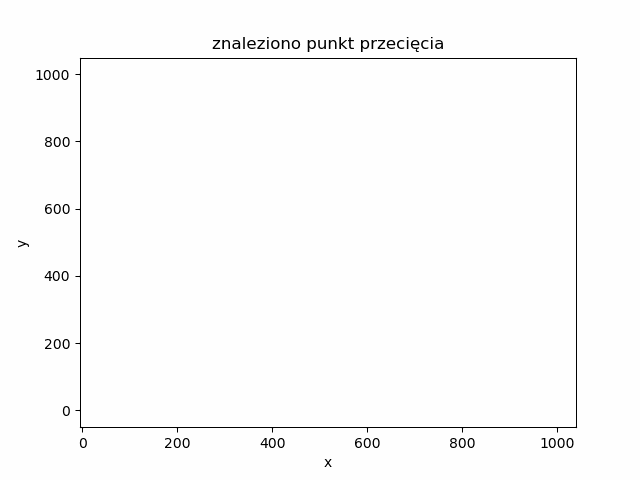

In [38]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(sections)
vis.show_gif(interval = 250)

Uzupełnij funkcję ```find_intersections```

In [39]:
def min_max(val1: float, val2: float):
    if val2 < val1:
        val1, val2 = val2, val1
    return val1, val2

In [40]:
def find_intersections_handle_event_beg(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersectionsTriplets: set[tuple[tuple[float, float], int, int]]):

    # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    eventSegment = event.get_event_segments_list()[0]

    broomStateStruct.add(eventSegment)

    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    assert(eventSegment == broomStateStruct[eventSegmentIdx])

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment: Segment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(eventSegment.get_idx(), precedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [precedingSegment, eventSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment: Segment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(eventSegment.get_idx(), succeedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [eventSegment, succeedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

In [41]:
def find_intersections_handle_event_end(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersectionsTriplets: set[tuple[tuple[float, float], float, float]]):

    # # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)

    assert(toRemoveSegment == broomStateStruct[toRemoveSegmentIdx])

    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    # sprawdzenie czy po usunięciu obecnego odcinka nowi sąsiedzi przecinają się
    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment: Segment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment: Segment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            segIdx1, segIdx2 = min_max(precedingSegment.get_idx(), succeedingSegment.get_idx())
            intersectionTriplet = (neighboursIntersectPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(neighboursIntersectPoint, eventType = INTERSECT, segmentsList = [precedingSegment, succeedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    broomStateStruct.remove(toRemoveSegment)

In [42]:
def find_intersections_handle_event_intersect(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                              intersectionsTriplets: set[tuple[tuple[float, float], float, float]]):

    prevPrecedingSegment, prevSucceedingSegment = event.get_event_segments_list()

    prevPrecedingSegmentIdx = broomStateStruct.bisect_left(prevPrecedingSegment)

    succeedingSegment, precedingSegment = prevPrecedingSegment, prevSucceedingSegment


    succeedingSegmentIdx = prevPrecedingSegmentIdx + 1

    assert(broomStateStruct[prevPrecedingSegmentIdx] == prevPrecedingSegment and broomStateStruct[succeedingSegmentIdx] == prevSucceedingSegment)

    if succeedingSegmentIdx < len(broomStateStruct) - 1:
        topNeighbour: Segment = broomStateStruct[succeedingSegmentIdx + 1]

        segmentsIntersectionPoint = get_segments_intersection(succeedingSegment, topNeighbour)
        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(succeedingSegment.get_idx(), topNeighbour.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [succeedingSegment, topNeighbour])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    precedingSegmentIdx = prevPrecedingSegmentIdx

    if precedingSegmentIdx > 0:
        bottomNeighbour: Segment = broomStateStruct[precedingSegmentIdx - 1]

        segmentsIntersectionPoint = get_segments_intersection(bottomNeighbour, precedingSegment)
        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(bottomNeighbour.get_idx(), precedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [bottomNeighbour, precedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    ####### zamiana odcinków miejscami  #######

    broomStateStruct.pop(prevPrecedingSegmentIdx)
    broomStateStruct.pop(prevPrecedingSegmentIdx)

    currentEventX = event.get_event_point().get_x()

    nextEvent: Event = eventsStateStruct[0]
    nextEventX = nextEvent.get_event_point().get_x()

    middleX = (currentEventX + nextEventX) / 2

    Segment.update_x(middleX)

    broomStateStruct.add(precedingSegment)
    broomStateStruct.add(succeedingSegment)

    ####### koniec zamiany #######

In [43]:
def find_intersections(segments):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param segments: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :return: zbiór punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    {((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...}
    """

    intersectionsTriplets = set()

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segmentsObjects = [Segment(i + 1, Point(segments[i][0]), Point(segments[i][1])) for i in range(len(segments))]

    for seg in segmentsObjects:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])
    prevEventX = firstEvent.get_event_point().get_x()

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()
        currentEventX = event.get_event_point().get_x()

        middleX = (prevEventX + currentEventX) / 2

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(middleX)

        if eventType == BEG:
            find_intersections_handle_event_beg(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        elif eventType == END:
            find_intersections_handle_event_end(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        elif eventType == INTERSECT:
            find_intersections_handle_event_intersect(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        else:
            raise Exception("Unknow Event type")

        prevEventX = currentEventX

    return intersectionsTriplets

Zwizualizujmy otrzymane przecięcia odcinków

{((np.float64(5.85908148723928), np.float64(5.381726038352546)), 1, 2), ((np.float64(3.578440561378344), np.float64(6.208872818271505)), 3, 4), ((np.float64(1.869564020698007), np.float64(4.467665440361686)), 4, 5), ((np.float64(4.773766883478362), np.float64(6.0596525787261495)), 1, 3), ((np.float64(6.617406969543431), np.float64(5.829499180284521)), 2, 3), ((np.float64(3.479498110222378), np.float64(3.976638710971137)), 2, 5), ((np.float64(3.9419352178177602), np.float64(6.579244558158069)), 1, 4)}


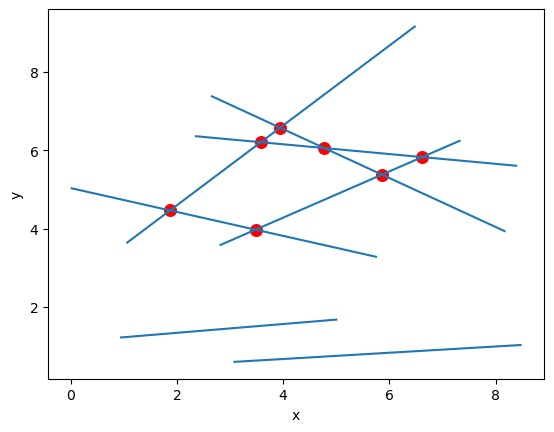

In [44]:
%matplotlib inline
intersections = find_intersections(segments)
print(intersections)
draw_intersections(segments, intersections)

{((np.float64(469.80467319127746), np.float64(672.9927515817715)), 7, 12), ((np.float64(650.5992106483168), np.float64(142.42049662761207)), 6, 11), ((np.float64(420.74126953878863), np.float64(564.9898351272918)), 2, 6), ((np.float64(343.0670048692295), np.float64(707.7856962640822)), 6, 8), ((np.float64(412.7166508309807), np.float64(569.8820884646204)), 1, 16), ((np.float64(354.67354020556576), np.float64(759.2954078160703)), 8, 12), ((np.float64(444.90598085065193), np.float64(691.6568889877956)), 12, 16), ((np.float64(713.6613298656434), np.float64(490.19704145855775)), 10, 12), ((np.float64(953.2588079597732), np.float64(561.210506655798)), 17, 19), ((np.float64(410.7852267547969), np.float64(562.57535727577)), 2, 16), ((np.float64(598.081617910876), np.float64(843.683341776848)), 7, 9), ((np.float64(295.6692675265111), np.float64(803.5251945758973)), 12, 20), ((np.float64(456.8154565132073), np.float64(405.7973726908367)), 13, 18), ((np.float64(672.4240832949977), np.float64(772

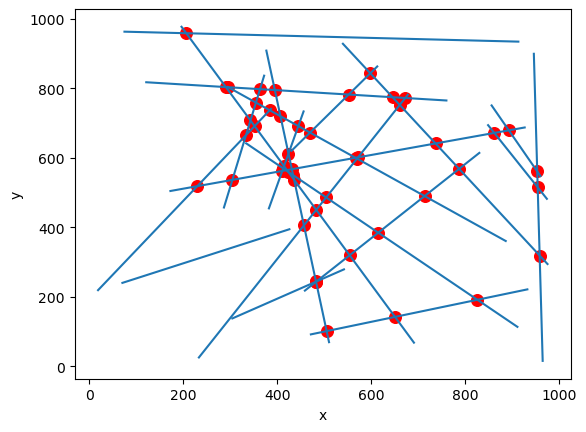

In [54]:
%matplotlib inline
loadedSegments2 = load_segments_from_file("./test_segments/test4")
intersections = find_intersections(loadedSegments2)
print(intersections)
draw_intersections(loadedSegments2, intersections)

In [46]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


Uzupełnij funkcję ```find_intersections_with_visualization```

In [55]:
def find_intersections_with_visualization_handle_event_beg(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersectionsTriplets: set[tuple[tuple[float, float], int, int]]):

    # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    eventSegment = event.get_event_segments_list()[0]

    broomStateStruct.add(eventSegment)

    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    assert(eventSegment == broomStateStruct[eventSegmentIdx])

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment: Segment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(eventSegment.get_idx(), precedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [precedingSegment, eventSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment: Segment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(eventSegment.get_idx(), succeedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [eventSegment, succeedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

In [56]:
def find_intersections_with_visualization_handle_event_end(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                                            intersectionsTriplets: set[tuple[tuple[float, float], float, float]]):

    # # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)

    assert(toRemoveSegment == broomStateStruct[toRemoveSegmentIdx])

    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    # sprawdzenie czy po usunięciu obecnego odcinka nowi sąsiedzi przecinają się
    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment: Segment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment: Segment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            segIdx1, segIdx2 = min_max(precedingSegment.get_idx(), succeedingSegment.get_idx())
            intersectionTriplet = (neighboursIntersectPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(neighboursIntersectPoint, eventType = INTERSECT, segmentsList = [precedingSegment, succeedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    broomStateStruct.remove(toRemoveSegment)

In [57]:
def find_intersections_with_visualization_handle_event_intersect(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                              intersectionsTriplets: set[tuple[tuple[float, float], float, float]]):

    prevPrecedingSegment, prevSucceedingSegment = event.get_event_segments_list()

    prevPrecedingSegmentIdx = broomStateStruct.bisect_left(prevPrecedingSegment)

    succeedingSegment, precedingSegment = prevPrecedingSegment, prevSucceedingSegment


    succeedingSegmentIdx = prevPrecedingSegmentIdx + 1

    assert(broomStateStruct[prevPrecedingSegmentIdx] == prevPrecedingSegment and broomStateStruct[succeedingSegmentIdx] == prevSucceedingSegment)

    if succeedingSegmentIdx < len(broomStateStruct) - 1:
        topNeighbour: Segment = broomStateStruct[succeedingSegmentIdx + 1]

        segmentsIntersectionPoint = get_segments_intersection(succeedingSegment, topNeighbour)
        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(succeedingSegment.get_idx(), topNeighbour.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [succeedingSegment, topNeighbour])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    precedingSegmentIdx = prevPrecedingSegmentIdx

    if precedingSegmentIdx > 0:
        bottomNeighbour: Segment = broomStateStruct[precedingSegmentIdx - 1]

        segmentsIntersectionPoint = get_segments_intersection(bottomNeighbour, precedingSegment)
        if segmentsIntersectionPoint is not None:
            segIdx1, segIdx2 = min_max(bottomNeighbour.get_idx(), precedingSegment.get_idx())
            intersectionTriplet = (segmentsIntersectionPoint.get_point(), segIdx1, segIdx2)
            if intersectionTriplet not in intersectionsTriplets:
                intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [bottomNeighbour, precedingSegment])
                intersectionsTriplets.add(intersectionTriplet)
                eventsStateStruct.add(intersectionEvent)

    ####### zamiana odcinków miejscami  #######

    broomStateStruct.pop(prevPrecedingSegmentIdx)
    broomStateStruct.pop(prevPrecedingSegmentIdx)

    currentEventX = event.get_event_point().get_x()

    nextEvent: Event = eventsStateStruct[0]
    nextEventX = nextEvent.get_event_point().get_x()

    middleX = (currentEventX + nextEventX) / 2

    Segment.update_x(middleX)

    broomStateStruct.add(precedingSegment)
    broomStateStruct.add(succeedingSegment)

    ####### koniec zamiany #######

In [68]:
def find_intersections_with_visualization(segments):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji
    :param segments: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

    vis = Visualizer()
    broom = None

    # wizualizacja odcinków
    vis.add_line_segment(segments, **NOT_PROCESSED_SEGMENTS)

    intersectionsTriplets = set()

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segmentsObjects = [Segment(i + 1, Point(segments[i][0]), Point(segments[i][1])) for i in range(len(segments))]

    points = []

    for seg in segmentsObjects:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)
        points.append(seg.get_beg().get_point())
        points.append(seg.get_end().get_point())

    # wizualizacja początkowych końców odcinków
    vis.add_point(points, **IN_EVENTS_STRUCT)

    firstEvent: Event = eventsSortedSet.pop(0)
    firstEventPoint = firstEvent.get_event_point()
    prevEventX = firstEventPoint.get_x()

    # wizualizacja pierwszego położenia miotły
    broom = vis.add_line(get_broom(firstEventPoint), **BROOM)
    vis.add_point(firstEventPoint.get_point(), **CURRENT_VERTEX)
    prevPoint = firstEventPoint

    firstSegment = firstEvent.get_event_segments_list()[0]
    broomStateStruct.add(firstSegment)

    # wizualizacja początkowego stanu struktury miotły
    vis.add_line_segment(firstSegment.get_segment(), **IN_BROOM_STRUCT)

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventPoint = event.get_event_point()
        eventType = event.get_event_type()
        currentEventX = eventPoint.get_x()

        middleX = (prevEventX + currentEventX) / 2

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(middleX)

        # wizualizacja przetworzenia wierzchołka
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)

        # wizualizacja przeniesienia miotły do nowego punktu
        vis.remove_figure(broom)
        broom = vis.add_line(get_broom(eventPoint), **BROOM)

        # wizualizacja przetwarzania obecnego wierzchołka
        vis.add_point(eventPoint.get_point(), **CURRENT_VERTEX)

        if eventType == BEG:
            find_intersections_with_visualization_handle_event_beg(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        elif eventType == END:
            find_intersections_with_visualization_handle_event_end(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        elif eventType == INTERSECT:
            find_intersections_with_visualization_handle_event_intersect(event, eventsSortedSet, broomStateStruct, intersectionsTriplets)
        else:
            raise Exception("Unknow Event type")

        prevEventX = currentEventX
        prevPoint = eventPoint

    # wizualizacja przecięć punktów
    vis.add_point([intersectionTriplet[0] for intersectionTriplet in intersectionsTriplets], **FOUND_INTERSECTION_POINT)

    return intersectionsTriplets, vis

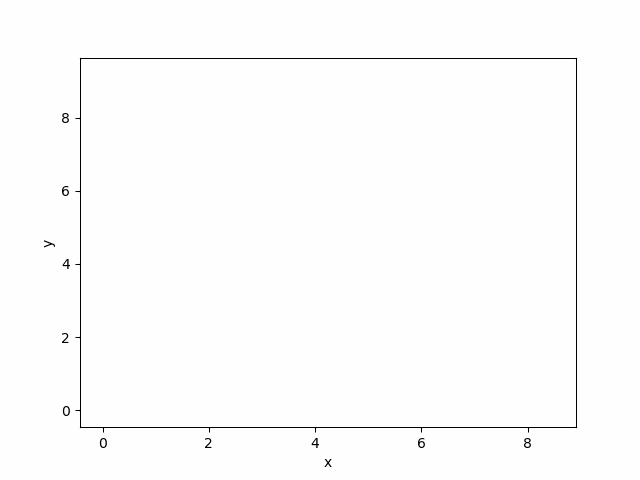

In [69]:
%matplotlib inline
intersections, vis = find_intersections_with_visualization(segments)
vis.show_gif(interval = 250)

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

In [48]:
# Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

In [49]:
# Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [50]:
# testing_sections = ???

In [51]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak?

In [52]:
# Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.